In [443]:
#Finding Putative Binding Sites Using Motifs and then Visualize them

import twobitreader as tbr
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from itertools import islice
import matplotlib.pyplot as plt

#Improvement TODO:
#I might make a fasta2twobit function in python later
#See if MEME can be incorporated into python
#probably  want to make a sequence class, pfm class, pwm class and peaks class to professionalize the code
#Fix the gzip problem
#Parallelize PWM Peak Search

#Lets start with devloping functions for reading pertinent files

#generate sequences in fasta and 2bit using biopython and twobitreader
#Don't use with gzipped files (It will unzip genome for every sequence)
#I'm going to use this function tbr to generate my sequences and revise my code
def genSeq(genome_path, chrom, chromstart, chromend):
    if bool(re.search('gz', genome_path)) | bool(re.search('fa', genome_path)) | bool(re.search('fasta', genome_path)):
        if bool(re.search('gz', genome_path)) == True:
            genome = SeqIO.parse(gzip.open(genome_path, 'rt'),'fasta')
            seq_gen = next(islice(genome, chrom , None))
            seq = str(seq_gen.seq[chromstart:chromend])
        else:
            genome = SeqIO.parse(open(genome_path),'fasta')
            seq_gen = next(islice(genome, chrom[:3] , None))
            seq = str(seq_gen.seq[chromstart:chromend])
    elif bool(re.search('2bit', genome_path)):
        tbGenome = tbr.TwoBitFile(genome_path)
        seq = tbGenome[chrom][chromstart:chromend]
    else:
        raise Exception('File type not recognized')
    return (seq).upper()

#This function will make a MEME-Chip and Homer ready fasta file for de novo motif searches
#Peaks is a path for your bed file or Narrow or Broad Peak file
#output is a output path
#The reference genome should be in twobit format (As of 2019, UCSC has twobit for most model organisms).
#This keeps the program lightweight and allows for way less memory usage. For more info click here (https://genome.ucsc.edu/goldenpath/help/twoBit.html)
#Revise with genSeq
def peak2fasta(peaks, genome, output, gzipped=False):
    f = open(output, 'w+')
    with open(peaks) as p:
        for line in p:
            if line.startswith('track') == False:
                i = list(line.split())
                f.write('>' + i[0] + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                        genSeq(genome, i[0], int(i[1]), int(i[2])) + '\n')
    if gzipped == True:
        with open(output, 'rb') as f_in, gzip.open(output + '.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    f.close()
    return "done writing file"

#Peak2Fasta for DNA2Vec
#Produce separate files for separate peaks
def peak2fasta_sep(peaks, genome, output, gzipped=False):
    with open(peaks) as p:
        for line in p:
            if line.startswith('track') == False:
                i = list(line.split())
                f = open(output + '_' + i[0] + '_' + i[1] + '_' + i[2], 'w+')
                f.write('>' + i[0] + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                        genSeq(genome, i[0], int(i[1]), int(i[2])) + '\n')
    if gzipped == True:
        with open(output, 'rb') as f_in, gzip.open(output + '.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    f.close()
    return "done writing files"

#path is a generic pfm path 
#Maybe expand to different motif formats
def read_pfm(path):
    pfm = []
    with open(path) as f:
        for line in f:
            if line.startswith('>'):
                continue
            elif re.match('^[A,C,T,G]', line):
                print('FileError: Wrong File Type')
            else:
                nuc_freqs = list(line.split())
                pfm.append(nuc_freqs)
    return np.asarray(pfm).astype(np.float)

#convert PFM to PWM
#bg is priors for all four nucleotides ACGT respectively
#pseudocount function for zero count positions
def pfm2pwm(pfm, pseudocount = 0.8, bg = [0.25, 0.25, 0.25, 0.25]):
    #chagnge into integer matrix
    pfm = np.trunc(pfm).astype(np.int)
    #Calculating Post Prob
    s = pseudocount
    bg_a = np.array(bg)
    bg_t = np.matrix(bg).transpose()
    N = np.sum(pfm[:,0])
    ppm = (pfm + (s*bg_t))/(N + s * np.sum(bg_a))
    #Calculate Weights
    norm_ppm = []
    for i in range(len(pfm)):
        norm = np.asarray(ppm[i]/(bg[i]/np.sum(bg_a))).reshape(-1)
        norm_ppm.append(norm.tolist())
    nppm = np.array(norm_ppm)
    pwm = np.log2(norm_ppm)
    return pwm

#One Hot Encoding Sequence
def oheSeq(DNAString):
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

#Creating Reverese Complements
def reverseComp(Seq):
    seq = Seq.upper()
    d = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    try:
        seq = seq[::-1]
        rc_seq = "".join([d[nuc] for nuc in seq])
    except KeyError:
        return "Not Viable DNA Seq"
    return rc_seq

#Search Sequence for sequence postion of DNA segments that match with a high enough score
def searchSeq(pwm, Seq, score, strand = '*', trim = 7):
    seqs = []
    Seq = Seq[trim:-trim]
    rc = reverseComp(Seq)
    #Normalize PWM
    max_score = sum([max(i) for i in pwm.T])
    min_score = sum([min(i) for i in pwm.T])
    n = len(pwm[0])
    unitScale = (pwm-(min_score/n))/(max_score-min_score)
    revUS = (pwm[:,::-1]-(min_score/n))/(max_score-min_score)
    #Chunk sequence into overlapping segments
    if strand == '*':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
        chunks.extend([Seq[i:i+n] for i in range(len(Seq)-n)])
    elif strand == '+':
        chunks = [Seq[i:i+n] for i in range(len(Seq)-n)]
    elif strand == '-':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
    for i in range(len(chunks)):
        OHESeq = oheSeq(chunks[i])
        seqScore = sum([np.matmul(OHESeq[j], unitScale[:,j]) for j in range(len(chunks[i]))])
        revSeqScore = sum([np.matmul(OHESeq[j], revUS[:,j]) for j in range(len(chunks[i]))])
        if seqScore >= score:
            seqs.append([chunks[i], seqScore, i-len(Seq), 'Forward'])
        if revSeqScore >= score:
            seqs.append([chunks[i], revSeqScore, i-len(Seq), 'Reverse'])
    seqs = np.array(seqs)
    if len(seqs) > 0:
        names = ['Sequence', 'Score', 'Pos', 'Orient']
        return pd.DataFrame(seqs, columns=names)
    else:
        return seqs

#Parallelizable searchSeq for ChipSeq using UCSC 2bit reader
#If you are having errors involving indexing, make sure you are using the right organism and version of your genome
#revise with genseq (will reduce the program length immensely)
def searchPeaks(pwm, peak_path, genome, score, strand = '*', threads = 1):
    names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
    motifDF = []
    motifQuant = []
    if threads == 1:
        if bool(re.search('gz', peak_path)):
            with gzip.open(peak_path, 'rt') as f:
                for line in f:
                    peak = list(line.split())
                    seq = genSeq(genome, peak[0], peak[1], peak[2])
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
        else:
            with open(peak_path) as f:
                for line in f:
                    peak = list(line.split())
                    seq = genSeq(genome, peak[0], peak[1], peak[2])
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
    else:
        return "Not Ready Yet"
    return pd.concat(motifDF), pd.DataFrame(motifQuant, columns= names)

#Genereate random sequences of length n
def randSeq(n, letters = 'ACGT'):
    code = dict((x,y) for x,y in enumerate(letters))
    encoded = np.random.randint(4, size = n)
    decode =  "".join([code[i] for i in encoded])
    return decode

#modified OHE for interspaced regions
def oheSeqMod(DNAString, flank_len):
    seq = DNAString.upper()
    flanks = seq[:6+flank_len] + seq[-6-flank_len:]
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in flanks]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.extend(letter)
    OHE.append(len(seq[6+flank_len:-6-flank_len]))
    return OHE


#Traditional PWM Search
#Takes a while currently
'''
search, dist = searchPeaks(pwm, '../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', '../data/mm10.2bit', 0.8, threads=1)
'''

#Regex Search
#Might want to combine with PWM here to explore larger Binding Site Space
'''
DR = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,10}?[AG]G[GT]TCA[AGCT]{5}'
IR = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,10}?ACT[GT]G[AG][AGCT]{5}'
ER1 = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,10}?[AG]G[GT]TCA[AGCT]{5}'
ER2 = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,10}?ACT[GT]G[AG][AGCT]{5}'
regBS = re.compile("(%s|%s|%s|%s)" % (DR,IR,ER1,ER2))
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/mm10.2bit')
with gzip.open('../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', 'rt') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2]})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)
n = 5
x = [len(i[6+n:-6-n]) for i in search_reg['binding']]
'''

#Dimensionality Reductions
'''
#euc for euclidean

euc_ohe =  np.array([oheSeqMod(i, 5) for i in search_reg['binding']])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap  
#Be careful with umap installation pip install umap will cause you to install the wrong ver of umap (and will also break the real module)

pca = PCA(n_components=2)
pca.fit(euc_ohe)
print(pca.explained_variance_ratio_)

#Takes a bit with larger datasets (scales n^2 in both compute time and memory)
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)

#Also takes a bit (even though they claim it is faster than TSNE)
umapped = umap.UMAP().fit_transform(euc_ohe)
'''

#Graphing example
'''
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.scatter(dim1, dim2)
plt.title("OHE Mod TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()
'''
#Getting Motifs for each cluster
'''
from Bio.Seq import Seq
from Bio import motifs

#Finding the flanking sequence logo for each cluster
cluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]
cluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]
cluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]
cluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]

clusters = [cluster1, cluster2, cluster3, cluster4]
for i in range(len(clusters)):
    instances = []
    for seq in clusters[i]:
        instances.append(Seq(seq[:6+n] + seq[-6-n:]))
    m = motifs.create(instances)
    m.weblogo('../data/motif_cluster' + str(i) + '.png')
'''

"\nfrom Bio.Seq import Seq\nfrom Bio import motifs\n\n#Finding the flanking sequence logo for each cluster\ncluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]\ncluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]\ncluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]\ncluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]\n\nclusters = [cluster1, cluster2, cluster3, cluster4]\nfor i in range(len(clusters)):\n    instances = []\n    for seq in clusters[i]:\n        instances.append(Seq(seq[:6+n] + seq[-6-n:]))\n    m = motifs.create(instances)\n    m.weblogo('../data/motif_cluster' + str(i) + '.png')\n"

In [52]:
#Creating file of sequences for MEME-Chip bash script
peak2fasta('../data/NR_NarrowPeaks/1739Hamner_PPARa_ucsctracks.bed', '../data/hg19.2bit', '../data/NR_NarrowPeaks/PPARAPeaks2.fasta', True)

'done writing file'

In [29]:
#Creating a set of fasta files for DNA2Vec Analysis of HN4A
peak2fasta_sep('../data/NR_NarrowPeaks/HN4A_peaks.bed', '../data/hg38.2bit', '../data/HN4APeaks/')

'done writing files'

In [191]:
#Creating a set of fasta files for DNA2Vec Analysis of Attac-Seq of liver
peak2fasta_sep('../data/liver_euchormatin/DNAAvail_peaks.narrowPeak', '../data/hg38.2bit', '../data/liver_euchormatin/OCPeak/')

'done writing files'

In [1]:
%%bash
#will take Nearly a day to run
KK
homeDir=/Users/omarkana/Documents/sudin_pipeline/data
wkPath=./tmp-$RANDOM
dataPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/CARSeqs.fasta
outputPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/motif_discovery

#INSTALL MEME Suite (You will need to check the dependencies on http://meme-suite.org/doc/install.html?man_type=web also will need to check perl dependencies)
cd $homeDir
mkdir -p $wkPath
cd  $wkPath
wget http://meme-suite.org/meme-software/5.0.5/meme-5.0.5.tar.gz
tar -zxf meme-5.0.5.tar.gz
cd meme-5.0.5
./configure --prefix=$HOME/meme --with-url=http://meme-suite.org/ --enable-build-libxml2 --enable-build-libxslt
make
make test
make install
export export PATH=$HOME/meme/bin:$PATH 
cd ../

#Get Hocomoco database to get relationships
wget http://hocomoco11.autosome.ru/final_bundle/hocomoco11/core/HUMAN/mono/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme

#Look at Doc @ http://meme-suite.org/doc/overview.html?man_type=web for more info on specifications
#I took out the centrimo-local parameter for speed reasons. 
meme-chip -o $outputPath -dna -meme-nmotifs 5 -dreme-e 0.01 -centrimo-local -db HOCOMOCOv11_core_HUMAN_mono_meme_format.meme* $dataPath

#copy relevant contents and delete
cd $homeDir
rm -rf $wkPath

bash: line 2: KK: command not found
bash: line 12: wget: command not found
tar: Error opening archive: Failed to open 'meme-5.0.5.tar.gz'
bash: line 14: cd: meme-5.0.5: No such file or directory
bash: line 15: ./configure: No such file or directory
make: *** No targets specified and no makefile found.  Stop.
make: *** No rule to make target `test'.  Stop.
make: *** No rule to make target `install'.  Stop.
bash: line 23: wget: command not found
Can't locate Globals.pm in @INC (you may need to install the Globals module) (@INC contains: /mnt/home/kanaomar/meme/lib/meme-5.0.5/perl /Library/Perl/5.18/darwin-thread-multi-2level /Library/Perl/5.18 /Network/Library/Perl/5.18/darwin-thread-multi-2level /Network/Library/Perl/5.18 /Library/Perl/Updates/5.18.2/darwin-thread-multi-2level /Library/Perl/Updates/5.18.2 /System/Library/Perl/5.18/darwin-thread-multi-2level /System/Library/Perl/5.18 /System/Library/Perl/Extras/5.18/darwin-thread-multi-2level /System/Library/Perl/Extras/5.18 .) at /Users

In [ ]:
%%bash
##INSTALLATION Script for HOMER
#Parameters
wkPath=/Users/omarkana/Documents/sudin_pipeline/data/HOMER

#INSTALL HOMER (You will need to check the dependencies on http://homer.ucsd.edu/homer/introduction/install.html)
#Make sure to edit your ~/.bash_profile and add PATH=$PATH:$wkPath (see instruction from website above)
mkdir -p $wkPath
cd  $wkPath

wget http://homer.ucsd.edu/homer/configureHomer.pl
perl configureHomer.pl -install 
echo "PATH="$PATH":"$wkPath >> ~/.bash_profile
source ~/.bash_profile

In [2]:
%%bash
##Use Homer on Custom Fasta file (there is a way to use a bigWig file if you have a reference genome using findMotifsGenome.pl found here http://homer.ucsd.edu/homer/motif/index.html)
kk
wkPath=/Users/omarkana/Documents/sudin_pipeline/data
dataPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/PPARAPeaks.fasta
outputPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/ppar_homer_discovery

cd $wkPath
#The longer the motifs you are looking for, the longer this will take. This is semi-parallelizable with -p
findMotifs.pl $dataPath fasta $outputPath -len 6,8,10,12 -S 20 

bash: line 2: kk: command not found
bash: line 9: findMotifs.pl: command not found


CalledProcessError: Command 'b'##Use Homer on Custom Fasta file (there is a way to use a bigWig file if you have a reference genome using findMotifsGenome.pl found here http://homer.ucsd.edu/homer/motif/index.html)\nkk\nwkPath=/Users/omarkana/Documents/sudin_pipeline/data\ndataPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/PPARAPeaks.fasta\noutputPath=/Users/omarkana/Documents/sudin_pipeline/data/NR_NarrowPeaks/ppar_homer_discovery\n\ncd $wkPath\n#The longer the motifs you are looking for, the longer this will take. This is semi-parallelizable with -p\nfindMotifs.pl $dataPath fasta $outputPath -len 6,8,10,12 -S 20 \n'' returned non-zero exit status 127.

In [442]:
pfm = read_pfm('../data/MF0004.1.pfm')
pwm = pfm2pwm(pfm)
search, dist = searchPeaks(pwm, '../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', '../data/mm10.2bit', 0.8, threads=1)

NameError: name 'pwm' is not defined

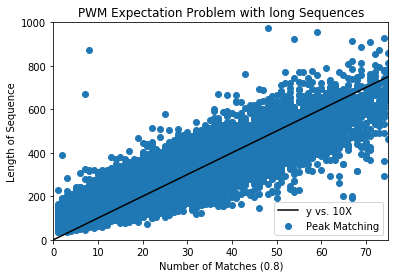

In [578]:
plt.scatter(dist['numOfMatches'], dist['lenSeq'], label = 'Peak Matching')
plt.xlabel('Number of Matches (0.8)')
plt.ylabel('Length of Sequence')
plt.xlim([0,75])
plt.ylim([0, 1000])
y = np.linspace(0, 1000, 200)
plt.plot(y/10, y, color = 'black', label = 'y vs. 10X')
plt.legend(loc = 'lower right')
plt.title('PWM Expectation Problem with long Sequences')
plt.show()

In [51]:
plt.hist(dist['numOfMatches'], bins=1000, density= -1)
plt.title('Negative Cummulative Distribution of Motif Matches')
plt.ylabel('Peak Fraction')
plt.xlabel('Matches/Peak')
plt.xlim([100,0])
plt.xticks(np.arange(0, 100, step = 8))
plt.show()

NameError: name 'dist' is not defined

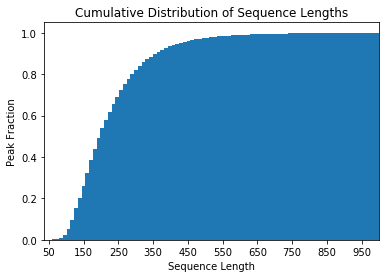

In [603]:
plt.hist(dist['lenSeq'], bins = 1000, density = True, cumulative=1)
plt.xlim([36, 1000])
plt.title('Cumulative Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Peak Fraction')
plt.xticks(np.arange(50,1000, step = 100))
plt.show()

In [446]:
#Finding Peaks using regex
#Make regex for RGKTCA
DR = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,8}?[AG]G[GT]TCA[AGCT]{5}'
IR = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,8}?ACT[GT]G[AG][AGCT]{5}'
ER1 = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,8}?[AG]G[GT]TCA[AGCT]{5}'
ER2 = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,8}?ACT[GT]G[AG][AGCT]{5}'
regBS = re.compile("(%s|%s|%s|%s)" % (DR,IR,ER1,ER2))
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/hg38.2bit')
with open('../data/PXRChipData/PXR_peaks.narrowPeak') as f:
    for line in f:
        if line.startswith('GL') == False and line.startswith('KI') == False:
            peak = list(line.split())
            if peak[0] == 'MT':
                seq = (genome['chrM'][int(peak[1]):int(peak[2])]).upper()
            else:
                seq = (genome['chr' + peak[0]][int(peak[1]):int(peak[2])]).upper()
            rSeq = reverseComp(seq)
            sequences = []
            for result in re.finditer(regBS, seq):
                sequences.append("".join(result.groups()))
            for result in re.finditer(regBS, rSeq):
                sequences.append("".join(result.groups()))
            if len(sequences) > 0:
                seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'PPARA'})
                motifDF.append(seqs)
                motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
genome2 = tbr.TwoBitFile('../data/mm10.2bit')
with gzip.open('../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', 'rt') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome2[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'CAR'})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
genome3 = tbr.TwoBitFile('../data/hg38.2bit')
with open('../data/NR_NarrowPeaks/HN4A_peaks.bed') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome3[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'HN4A'})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)

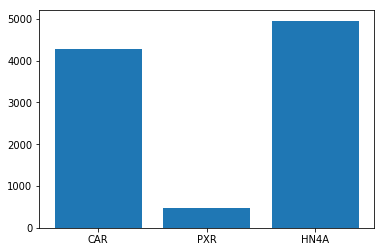

In [448]:
#Bar Graph of binding sites
xs = []
for i in ['CAR', 'PPARA', 'HN4A']:
    xs.append([len(j[6+n:-6-n]) for j in search_reg['binding'][search_reg['NR']==i]])
plt.bar(x = [1,2,3], height = [len(i) for i in xs], tick_label = ['CAR', 'PXR', 'HN4A'])
plt.savefig('../figs/PeakDist.tif', dpi = 600)
plt.show()

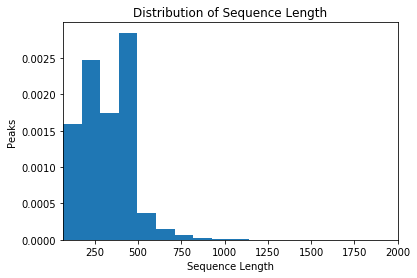

In [449]:
#Entire Distribution of sequences
#Maximum is at around 10^5 bp and the min is about 35 from memory
n = 5
x = [len(i[6+n:-6-n]) for i in search_reg['binding']]
plt.hist(dist_reg['lenSeq'], bins = 100, density = True)
plt.title('Distribution of Sequence Length')
plt.xlim([min(dist_reg['lenSeq']),2000])
plt.ylabel('Peaks')
plt.xlabel('Sequence Length')
plt.savefig('../figs/seqLenDist.tif', dpi = 600)
plt.show()

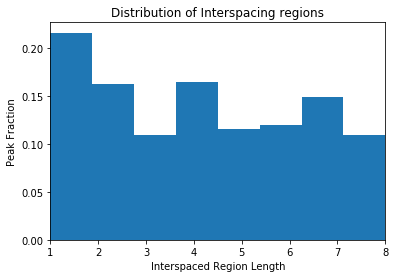

In [450]:
#Entire Distribution for all Three TF
plt.hist(x, density = True, bins = 8)
plt.title('Distribution of Interspacing regions')
plt.ylabel('Peak Fraction')
plt.xlabel('Interspaced Region Length')
plt.xlim([1,8])
plt.savefig('../figs/interLenDist.tif', dpi = 600)
plt.show()

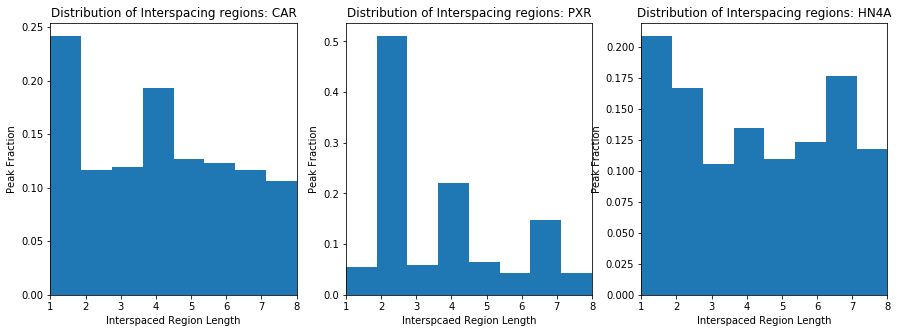

In [338]:
#Distribution for individual Transcription Factors
#Collecting Data
xs = []
for i in ['CAR', 'PPARA', 'HN4A']:
    xs.append([len(j[6+n:-6-n]) for j in search_reg['binding'][search_reg['NR']==i]])
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
ax[0].hist(xs[0], density = True, bins = 8)
ax[0].set_title('Distribution of Interspacing regions: CAR')
ax[0].set_ylabel('Peak Fraction')
ax[0].set_xlabel('Interspaced Region Length')
ax[0].set_xlim([1,8])
#PPAR
ax[1].hist(xs[1], density = True, bins = 8)
ax[1].set_title('Distribution of Interspacing regions: PXR')
ax[1].set_ylabel('Peak Fraction')
ax[1].set_xlabel('Interspcaed Region Length')
ax[1].set_xlim([1,8])
#HN4A
ax[2].hist(xs[2], density = True, bins = 8)
ax[2].set_title('Distribution of Interspacing regions: HN4A')
ax[2].set_ylabel('Peak Fraction')
ax[2].set_xlabel('Interspaced Region Length')
ax[2].set_xlim([1,8])
fig.savefig('../figs/IndInterLenDist.tif', dpi = 600)
plt.show()

In [216]:
len(search_reg['binding'].values.tolist())

9727

In [493]:
euc_ohe =  np.array([oheSeqMod(i, 5) for i in search_reg['binding']])
euc_ohe_car = np.array([oheSeqMod(i, 5) for i in search_reg['binding'][search_reg['NR']=='CAR']])
euc_ohe_ppar = np.array([oheSeqMod(i, 5) for i in search_reg['binding'][search_reg['NR']=='PPARA']])
euc_ohe_hn4a = np.array([oheSeqMod(i, 5) for i in search_reg['binding'][search_reg['NR']=='HN4A']])

In [453]:
 from sklearn.decomposition import PCA

In [454]:
pca = PCA(n_components=2)
pcac = PCA(n_components=2)
pcap = PCA(n_components=2)
pcah = PCA(n_components=2)
pca.fit(euc_ohe)
pcac.fit(euc_ohe_car)
pcap.fit(euc_ohe_ppar)
pcah.fit(euc_ohe_hn4a)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [455]:
print(pca.explained_variance_ratio_)

[0.32404715 0.08890934]


In [456]:
print(pca.singular_values_) 

[234.56063896 122.86402026]


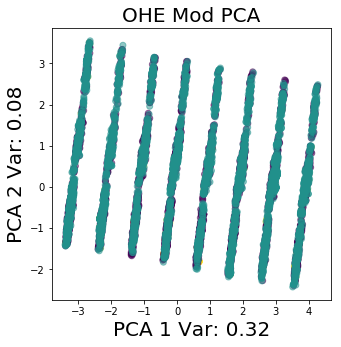

In [457]:
NR = search_reg['NR'].astype('category').cat.codes
pca_coord = pca.transform(euc_ohe)
plt.figure(figsize = [5,5])
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
plt.scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
plt.title("OHE Mod PCA", fontsize = 20)
plt.xlabel('PCA 1 Var: ' + str(pca.explained_variance_ratio_[0])[:4], fontsize = 20 )
plt.ylabel('PCA 2 Var: ' + str(pca.explained_variance_ratio_[1])[:4], fontsize = 20)
plt.savefig('../figs/ohePCA.tif', dpi = 600)
plt.show()

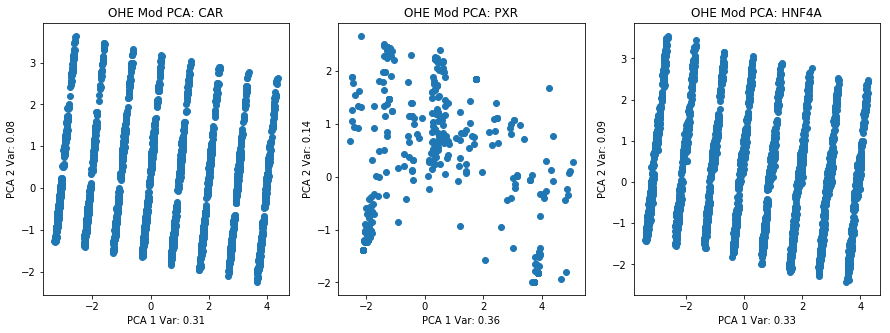

In [352]:
#PCA Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
pcac_coord = pcac.transform(euc_ohe_car)
dim1c = pcac_coord[:, 0]
dim2c = pcac_coord[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("OHE Mod PCA: CAR")
ax[0].set_xlabel('PCA 1 Var: '+ str(pcac.explained_variance_ratio_[0])[:4])
ax[0].set_ylabel('PCA 2 Var: ' + str(pcac.explained_variance_ratio_[1])[:4])
#PPAR
pcap_coord = pcap.transform(euc_ohe_ppar)
dim1p = pcap_coord[:, 0]
dim2p = pcap_coord[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("OHE Mod PCA: PXR")
ax[1].set_xlabel('PCA 1 Var: ' + str(pcap.explained_variance_ratio_[0])[:4])
ax[1].set_ylabel('PCA 2 Var: ' + str(pcap.explained_variance_ratio_[1])[:4])
#HN4A
pcah_coord = pca.transform(euc_ohe_hn4a)
dim1h = pcah_coord[:, 0]
dim2h = pcah_coord[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("OHE Mod PCA: HNF4A")
ax[2].set_xlabel('PCA 1 Var: ' + str(pcah.explained_variance_ratio_[0])[:4])
ax[2].set_ylabel('PCA 2 Var: ' + str(pcah.explained_variance_ratio_[1])[:4])
fig.savefig('../figs/IndOhePCA.tif', dpi = 600)
plt.show()

In [224]:
from sklearn.manifold import TSNE

In [495]:
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)
X_car = TSNE(n_components=2).fit_transform(euc_ohe_car)
X_ppar = TSNE(n_components=2).fit_transform(euc_ohe_ppar)
X_hn4a = TSNE(n_components=2).fit_transform(euc_ohe_hn4a)

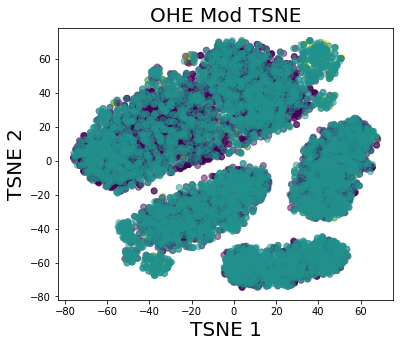

In [497]:
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.figure(figsize = [6,5])
plt.scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
plt.title("OHE Mod TSNE", fontsize = 20)
plt.xlabel('TSNE 1', fontsize = 20)
plt.ylabel('TSNE 2', fontsize = 20)
plt.savefig('../figs/oheTsne.tif', dpi = 600)
plt.show()

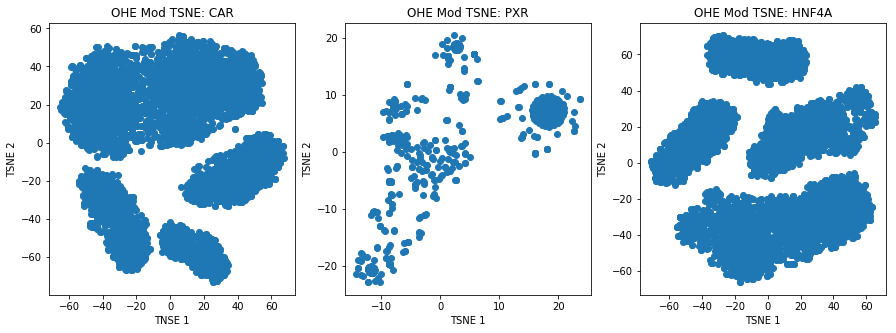

In [354]:
#TSNE Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = X_car[:, 0]
dim2c = X_car[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("OHE Mod TSNE: CAR")
ax[0].set_xlabel('TNSE 1')
ax[0].set_ylabel('TSNE 2')
#PPAR
dim1p = X_ppar[:, 0]
dim2p = X_ppar[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("OHE Mod TSNE: PXR")
ax[1].set_xlabel('TSNE 1')
ax[1].set_ylabel('TSNE 2')
#HN4A
dim1h = X_hn4a[:, 0]
dim2h = X_hn4a[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("OHE Mod TSNE: HNF4A")
ax[2].set_xlabel('TSNE 1')
ax[2].set_ylabel('TSNE 2')
fig.savefig('../figs/IndOheTsne.tif', dpi = 600)
plt.show()

In [250]:
import umap

In [460]:
umapped = umap.UMAP().fit_transform(euc_ohe)
umapc = umap.UMAP().fit_transform(euc_ohe_car)
umapp = umap.UMAP().fit_transform(euc_ohe_ppar)
umaph = umap.UMAP().fit_transform(euc_ohe_hn4a)

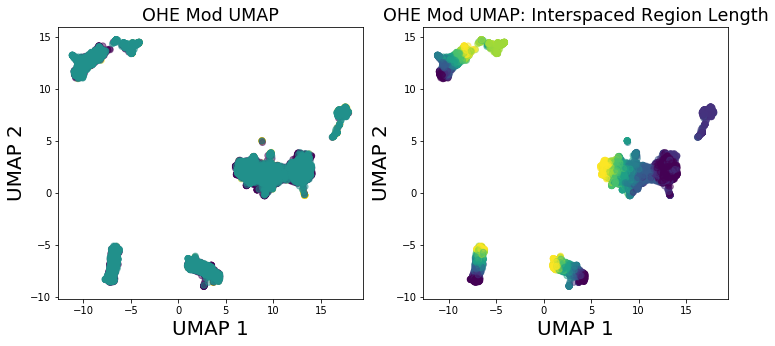

In [480]:
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
fig, ax = plt.subplots(1,2,figsize = [12,5])
ax[1].scatter(dim1, dim2, c=x, cmap='viridis', alpha=0.5)
ax[0].scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
ax[1].set_title("OHE Mod UMAP: Interspaced Region Length", fontsize = 17.5)
ax[0].set_title("OHE Mod UMAP", fontsize = 17.5)
ax[0].set_xlabel('UMAP 1', fontsize = 20)
ax[0].set_ylabel('UMAP 2', fontsize = 20)
ax[1].set_xlabel('UMAP 1', fontsize = 20)
ax[1].set_ylabel('UMAP 2', fontsize = 20)
plt.savefig('../figs/oheUmapLen2.tif', dpi = 600)
plt.show()

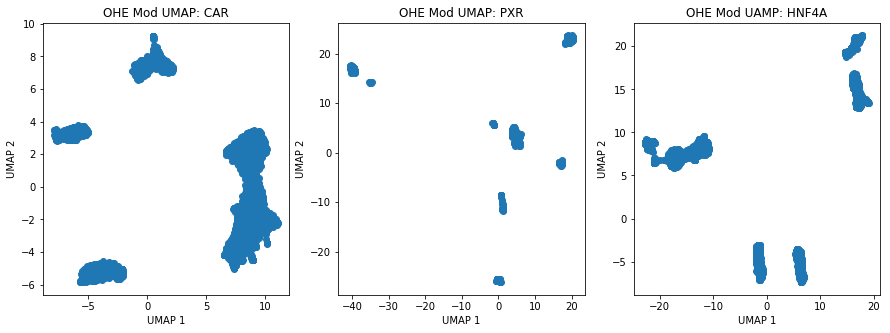

In [356]:
#UMAP Projections of individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = umapc[:, 0]
dim2c = umapc[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("OHE Mod UMAP: CAR")
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
#PPAR
dim1p = umapp[:, 0]
dim2p = umapp[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("OHE Mod UMAP: PXR")
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
#HN4A
dim1h = umaph[:, 0]
dim2h = umaph[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("OHE Mod UAMP: HNF4A")
ax[2].set_xlabel('UMAP 1')
ax[2].set_ylabel('UMAP 2')
fig.savefig('../figs/IndOheUmap.tif', dpi = 600)
plt.show()

In [62]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters = 4).fit_predict(umapped)
search_reg['labels'] = labels
search_reg['interspace'] = x
search_reg.sort_values('labels')

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [468]:
from sklearn.cluster import SpectralClustering
labels = SpectralClustering(n_clusters=4).fit(umapped)
search_reg['labels'] = labels.labels_
search_reg['interspace'] = x
search_reg.sort_values('labels') 

,binding,chrom,chromstart,chromend,NR,labels,interspace
0,TCACGAGGTCAGGAGTTCAAGACC,1,9064822,9065000,PPARA,0,2
0,TTGTTGGGTCATAGGTCATGTTT,chr4,169652437,169652841,HN4A,0,1
0,ACCTGAGGTCAGGAGTTCAAGACC,chr9,134285499,134285903,HN4A,0,2
0,ACCTGAGGTCAAGAGTTCAAGGTC,chr12,2887018,2887422,HN4A,0,2
0,TTGCTGGGTCATAAGGTCAAGTTA,chr20,12977787,12978191,HN4A,0,2
0,ACCTGAGGTCAGGAGTTCAAGAGC,chr22,20899829,20900233,HN4A,0,2
0,TGTACAGGTCAGATAGCGGGGTCAATGAA,chr5,156332198,156332602,HN4A,0,7
0,GTGCCGGGTCATCCGAGTCGGGTCACGTGG,chr14,77097943,77098347,HN4A,0,8
0,ACCTGAGGTCAGGAGTTCAAGACC,chr10,97448298,97448702,HN4A,0,2
0,TTTCTGGGTCAGACTATAAGTTCAATTAA,chr4,64301299,64301703,HN4A,0,7


In [470]:
from Bio.Seq import Seq
from Bio import motifs

In [472]:
#Finding the flanking sequence logo for each cluster
cluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]
cluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]
cluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]
cluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]

clusters = [cluster1, cluster2, cluster3, cluster4]
for i in range(len(clusters)):
    instances = []
    for seq in clusters[i]:
        instances.append(Seq(seq[:6+n] + seq[-6-n:]))
    m = motifs.create(instances)
    m.weblogo('../data/motif_cluster' + str(i) + '.png', dpi = 600, size = 'large')

In [22]:
motif = '[AGC]TGA[CTG][ATCG][CAT][AGT]GC[ATCG]'
regBS = re.compile(motif)
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/hg19.2bit')
with open('/Users/omarkana/Downloads/ENCFF126HBJ.bed') as f:
    for line in f:
        if line.startswith('track') == False:
            peak = list(line.split())
            seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
            rSeq = reverseComp(seq)
            sequences = []
            sequences.extend(re.findall(regBS, seq))
            sequences.extend(re.findall(regBS, rSeq))
            if len(sequences) > 0:
                seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'NRF2'})
                motifDF.append(seqs)
                motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)
search_reg

,binding,chrom,chromstart,chromend,NR
0,ATGACTCAGCA,chr10,5113978,5114231,NRF2
0,ATGACACAGCA,chr20,48909147,48909439,NRF2
0,ATGACTCAGCA,chr6,143730457,143730733,NRF2
0,GTGACTCAGCG,chr22,35767953,35768232,NRF2
1,GTGACTCAGCG,chr22,35767953,35768232,NRF2
2,GTGACTTAGCG,chr22,35767953,35768232,NRF2
3,GTGACTCAGCA,chr22,35767953,35768232,NRF2
0,ATGACTCAGCA,chr16,73054395,73054618,NRF2
0,ATGACTCAGCA,chr7,92439077,92439320,NRF2
0,CTGAGGAGGCA,chr22,35773004,35773256,NRF2


In [24]:
search_reg.to_csv('../data/nrf2BindingSites.csv')
dist_reg.to_csv('../data/nrf2BSMeta.csv')

In [ ]:
#euc for euclidean
euc_ohe =  np.array([oheSeq(i) for i in search_reg['binding']])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap  
#Be careful with umap installation pip install umap will cause you to install the wrong ver of umap (and will also break the real module)

pca = PCA(n_components=2)
pca.fit(euc_ohe)
print(pca.explained_variance_ratio_)

#Takes a bit with larger datasets (scales n^2 in both compute time and memory)
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)

#Also takes a bit (even though they claim it is faster than TSNE)
umapped = umap.UMAP().fit_transform(euc_ohe)

In [473]:
### Importing DNA2Vec Encoding ###
## Multi K Model from DNA2Vec Github ##
from __future__ import print_function

import logbook
import tempfile
import numpy as np

from gensim.models import word2vec
from gensim import matutils
from gensim.models import KeyedVectors

class SingleKModel:
    def __init__(self, model):
        self.model = model
        self.vocab_lst = sorted(model.vocab.keys())

class MultiKModel:
    def __init__(self, filepath):
        self.aggregate = KeyedVectors.load_word2vec_format(filepath, binary=False)
        self.logger = logbook.Logger(self.__class__.__name__)

        vocab_lens = [len(vocab) for vocab in self.aggregate.vocab.keys()]
        self.k_low = min(vocab_lens)
        self.k_high = max(vocab_lens)
        self.vec_dim = self.aggregate.vector_size

        self.data = {}
        for k in range(self.k_low, self.k_high + 1):
            self.data[k] = self.separate_out_model(k)

    def model(self, k_len):
        """
        Use vector('ACGTA') when possible
        """
        return self.data[k_len].model

    def vector(self, vocab):
        return self.data[len(vocab)].model[vocab]

    def unitvec(self, vec):
        return matutils.unitvec(vec)

    def cosine_distance(self, vocab1, vocab2):
        return np.dot(self.unitvec(self.vector(vocab1)), self.unitvec(self.vector(vocab2)))

    def l2_norm(self, vocab):
        return np.linalg.norm(self.vector(vocab))

    def separate_out_model(self, k_len):
        vocabs = [vocab for vocab in self.aggregate.vocab.keys() if len(vocab) == k_len]
        if len(vocabs) != 4 ** k_len:
            self.logger.warn('Missing {}-mers: {} / {}'.format(k_len, len(vocabs), 4 ** k_len))

        header_str = '{} {}'.format(len(vocabs), self.vec_dim)
        with tempfile.NamedTemporaryFile(mode='w') as fptr:
            print(header_str, file=fptr)
            for vocab in vocabs:
                vec_str = ' '.join("%f" % val for val in self.aggregate[vocab])
                print('{} {}'.format(vocab, vec_str), file=fptr)
            fptr.flush()
            return SingleKModel(KeyedVectors.load_word2vec_format(fptr.name, binary=False))

In [474]:
## Testing Encoding Recall ##
filepath = '../data/hg38/dna2vec-20190508-1815-k1to8-100d-10c-31500Mbp-sliding-czf.w2v'
mk_model = MultiKModel(filepath)

In [475]:
### Defining Encoding Function ###
def w2vEncode(string, model, flank_len):
    enc = []
    flank1 = string[:flank_len]
    motif1 = string[flank_len:flank_len+6]
    inter = string[flank_len+6:-6-flank_len]
    motif2 = string[-flank_len-6:-flank_len]
    flank2 = string[-flank_len:]
    bsStruct = [flank1, motif1, inter, motif2, flank2]
    for i in bsStruct:
        e = model.vector(i).tolist()
        enc.extend(e)
    return np.array(enc)

In [476]:
euc_w2v =  np.array([w2vEncode(i, mk_model, 5) for i in search_reg['binding']])
euc_w2v_car = np.array([w2vEncode(i, mk_model, 5) for i in search_reg['binding'][search_reg['NR']=='CAR']])
euc_w2v_ppar = np.array([w2vEncode(i, mk_model, 5) for i in search_reg['binding'][search_reg['NR']=='PPARA']])
euc_w2v_hn4a = np.array([w2vEncode(i, mk_model, 5) for i in search_reg['binding'][search_reg['NR']=='HN4A']])

In [477]:
pca = PCA(n_components=2)
pcac = PCA(n_components=2)
pcap = PCA(n_components=2)
pcah = PCA(n_components=2)
pca.fit(euc_w2v)
pcac.fit(euc_w2v_car)
pcap.fit(euc_w2v_ppar)
pcah.fit(euc_w2v_hn4a)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [478]:
print(pca.explained_variance_ratio_)

[0.08088789 0.05949126]


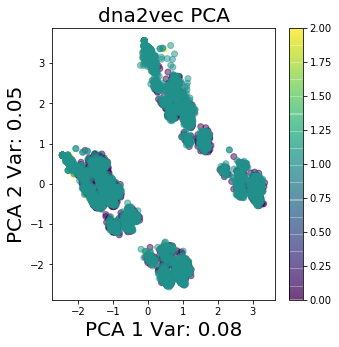

In [510]:
NR = search_reg['NR'].astype('category').cat.codes
pca_coord = pca.transform(euc_w2v)
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
plt.figure(figsize = [5,5])
plt.scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
plt.title("dna2vec PCA", fontsize = 20)
plt.xlabel('PCA 1 Var: ' + str(pca.explained_variance_ratio_[0])[:4], fontsize = 20)
plt.ylabel('PCA 2 Var: '+ str(pca.explained_variance_ratio_[1])[:4], fontsize = 20)
plt.colorbar()
plt.show()

In [522]:
print(NR[:1000])
print(search_reg['NR'][:1000])

0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
0    2
    ..
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
1    0
0    0
0    0
1    0
0    0
1    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    0
Length: 1000, dtype: int8
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
0    PPARA
     ...  
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
0      CAR
1      CAR
0      CAR
0      CAR
1      C

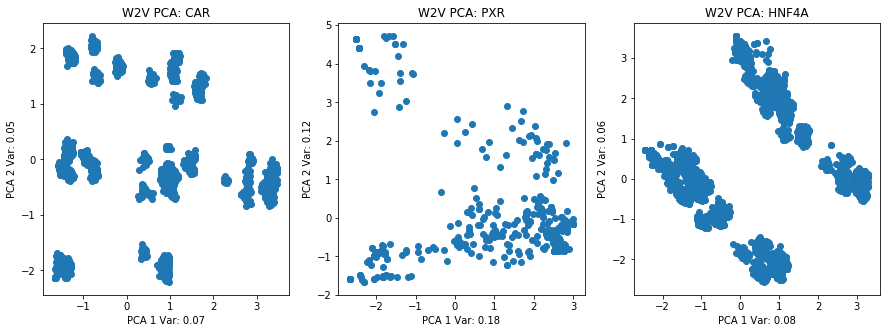

In [361]:
#PCA Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
pcac_coord = pcac.transform(euc_w2v_car)
dim1c = pcac_coord[:, 0]
dim2c = pcac_coord[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V PCA: CAR")
ax[0].set_xlabel('PCA 1 Var: ' + str(pcac.explained_variance_ratio_[0])[:4])
ax[0].set_ylabel('PCA 2 Var: '+ str(pcac.explained_variance_ratio_[1])[:4])
#PPAR
pcap_coord = pcap.transform(euc_w2v_ppar)
dim1p = pcap_coord[:, 0]
dim2p = pcap_coord[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V PCA: PXR")
ax[1].set_xlabel('PCA 1 Var: ' + str(pcap.explained_variance_ratio_[0])[:4])
ax[1].set_ylabel('PCA 2 Var: '+ str(pcap.explained_variance_ratio_[1])[:4])
#HN4A
pcah_coord = pca.transform(euc_w2v_hn4a)
dim1h = pcah_coord[:, 0]
dim2h = pcah_coord[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V PCA: HNF4A")
ax[2].set_xlabel('PCA 1 Var: ' + str(pcah.explained_variance_ratio_[0])[:4])
ax[2].set_ylabel('PCA 2 Var: '+ str(pcah.explained_variance_ratio_[1])[:4])
fig.savefig('../figs/Indw2vPCA.tif', dpi = 600)
plt.show()

In [500]:
X_embedded = TSNE(n_components=2).fit_transform(euc_w2v)
X_car = TSNE(n_components=2).fit_transform(euc_w2v_car)
X_ppar = TSNE(n_components=2).fit_transform(euc_w2v_ppar)
X_hn4a = TSNE(n_components=2).fit_transform(euc_w2v_hn4a)

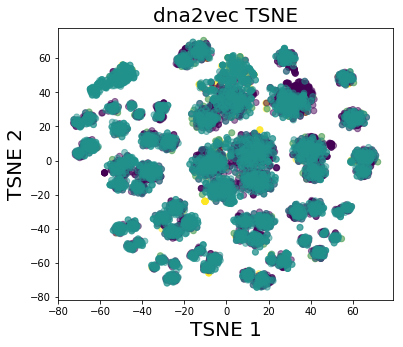

In [503]:
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.figure(figsize = [6,5])
plt.scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
plt.title("dna2vec TSNE", fontsize = 20)
plt.xlabel('TSNE 1', fontsize = 20)
plt.ylabel('TSNE 2', fontsize = 20)
plt.savefig("../w2vTsne.tif", dpi = 600)
plt.show()

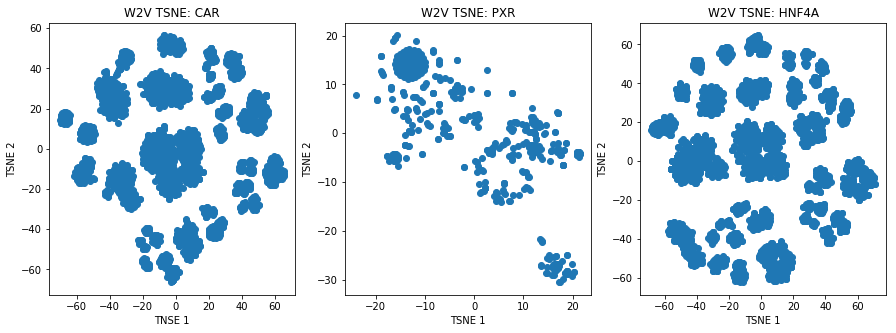

In [363]:
#TSNE Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = X_car[:, 0]
dim2c = X_car[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V TSNE: CAR")
ax[0].set_xlabel('TNSE 1')
ax[0].set_ylabel('TSNE 2')
#PPAR
dim1p = X_ppar[:, 0]
dim2p = X_ppar[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V TSNE: PXR")
ax[1].set_xlabel('TSNE 1')
ax[1].set_ylabel('TSNE 2')
#HN4A
dim1h = X_hn4a[:, 0]
dim2h = X_hn4a[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V TSNE: HNF4A")
ax[2].set_xlabel('TSNE 1')
ax[2].set_ylabel('TSNE 2')
fig.savefig('../IndW2vTsne.tif', dpi = 600)
plt.show()

In [512]:
umapped = umap.UMAP().fit_transform(euc_w2v)
umapc = umap.UMAP().fit_transform(euc_w2v_car)
umapp = umap.UMAP().fit_transform(euc_w2v_ppar)
umaph = umap.UMAP().fit_transform(euc_w2v_hn4a)

/Users/omarkana/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

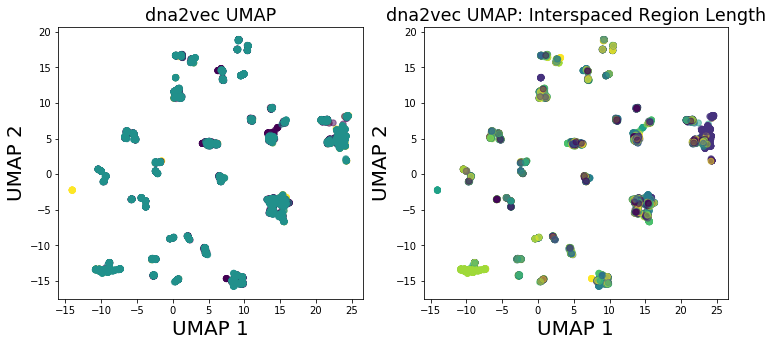

In [515]:
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
fig , ax = plt.subplots(1,2, figsize = [12,5])
ax[0].scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
ax[0].set_title("dna2vec UMAP", fontsize = 17.5)
ax[0].set_xlabel('UMAP 1', fontsize = 20)
ax[0].set_ylabel('UMAP 2', fontsize = 20)

ax[1].scatter(dim1, dim2, c=x, cmap='viridis', alpha=0.5)
ax[1].set_title("dna2vec UMAP: Interspaced Region Length", fontsize = 17.5)
ax[1].set_xlabel('UMAP 1', fontsize = 20)
ax[1].set_ylabel('UMAP 2', fontsize = 20)
plt.colormaps()
plt.show()

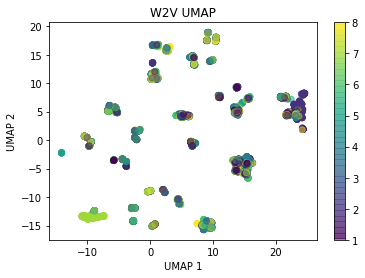

In [519]:
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
plt.scatter(dim1, dim2, c=x, cmap='viridis', alpha=0.5)
plt.title("W2V UMAP")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.savefig('../figs/colorbar.tif', dpi = 600)
plt.show()

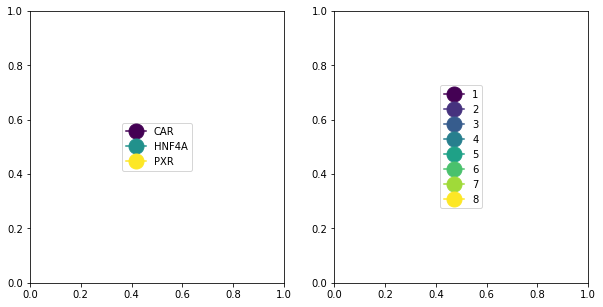

In [546]:
from matplotlib.lines import Line2D
from matplotlib import cm

cmap = plt.cm.viridis
legend_elements1 = [Line2D([0], [0],linestyle= '-', color = cmap(0.), marker = 'o', markersize = 15,label = 'CAR'),
                  Line2D([0], [0], linestyle= '-',color = cmap(0.5), marker = 'o',markersize = 15, label = 'HNF4A'),
                  Line2D([0], [0], linestyle= '-',color = cmap(1.), marker = 'o',markersize = 15, label = 'PXR')]
legend_elements2 = []
for i in range(8):
    legend_elements2.append(Line2D([0], [0],linestyle= '-', color = cmap(i/7), marker = 'o', markersize = 15,label = str(i+1)))
fig, ax = plt.subplots(1,2, figsize = [10,5])
ax[0].legend(handles=legend_elements1, loc='center')
ax[1].legend(handles = legend_elements2, loc = 'center')
fig.savefig('../figs/colorbar.tif', dpi = 600)
plt.show()        

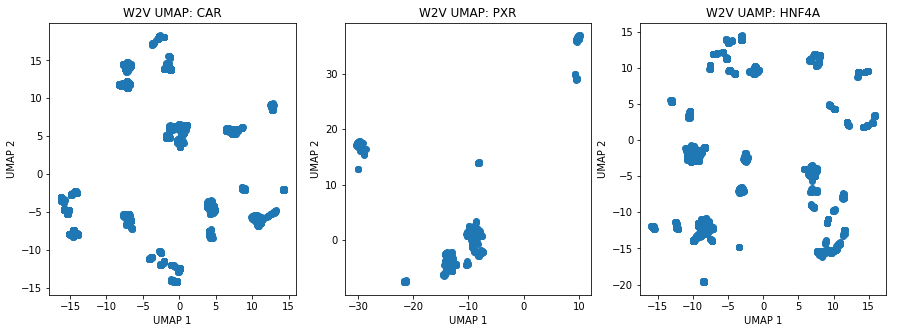

In [365]:
#UMAP Projections of individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = umapc[:, 0]
dim2c = umapc[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V UMAP: CAR")
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
#PPAR
dim1p = umapp[:, 0]
dim2p = umapp[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V UMAP: PXR")
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
#HN4A
dim1h = umaph[:, 0]
dim2h = umaph[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V UAMP: HNF4A")
ax[2].set_xlabel('UMAP 1')
ax[2].set_ylabel('UMAP 2')
plt.savefig('../figs/IndW2vUmap.tif', dpi = 600)
plt.show()

In [487]:
# Word2Vec Visualization
w2v_agn = pd.read_csv('../data/hg38/dna2vec-20190508-1815-k1to8-100d-10c-31500Mbp-sliding-czf.w2v', header = None, delim_whitespace = True, skiprows = 1, engine = 'c')
w2v_words = w2v_agn.iloc[:, 0].values
w2v_vecs = w2v_agn.iloc[:, 1:].values
w2v_agn = []

[0.05364849 0.02995797]
0.772976058420468


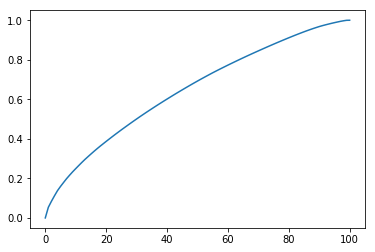

In [323]:
# PCA
PCAFULL = PCA()
pca.fit(w2v_vecs)
PCAFULL.fit(w2v_vecs)
print(pca.explained_variance_ratio_)
w2v_pca = pca.transform(w2v_vecs)
var = PCAFULL.explained_variance_ratio_
var_sum = 0
cum_var = [0]
for i in var:
    var_sum += i
    cum_var.append(var_sum)
print(cum_var[60])
plt.plot(cum_var)
plt.show()

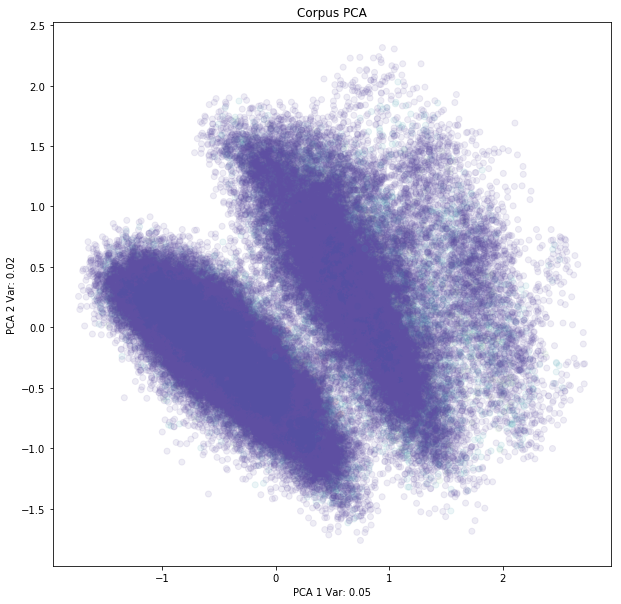

In [325]:
# PCA didn't work, but I'll plot it
dim1 = w2v_pca[:, 0]
dim2 = w2v_pca[:, 1]
lens = [len(i) for i in w2v_words]
plt.figure(figsize = [10, 10])
plt.scatter(dim1, dim2, c = lens, cmap='Spectral', alpha=0.1)
plt.title("Corpus PCA")
plt.xlabel('PCA 1 Var: '+ str(pca.explained_variance_ratio_[0])[:4])
plt.ylabel('PCA 2 Var: '+ str(pca.explained_variance_ratio_[1])[:4])
plt.savefig('../figs/corpusPCA.tif', dpi = 600)
plt.show()

In [488]:
#Lets try UMAP
umapped = umap.UMAP().fit_transform(w2v_vecs)

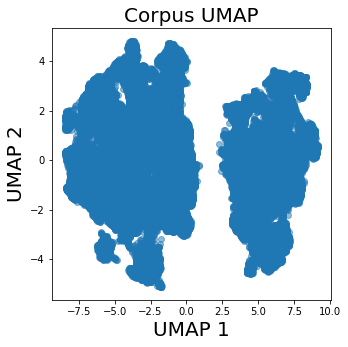

In [489]:
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
plt.figure(figsize=[5,5])
plt.scatter(dim1, dim2, alpha=0.5)
plt.title("Corpus UMAP", fontsize = 20)
plt.xlabel('UMAP 1', fontsize = 20)
plt.ylabel('UMAP 2', fontsize = 20)
plt.savefig('../figs/corpusUMAP.tif', dpi = 600)
plt.show()

In [330]:
#Lets Try TSNE
ctsne = TSNE(n_components = 2).fit_transform(w2v_vecs)

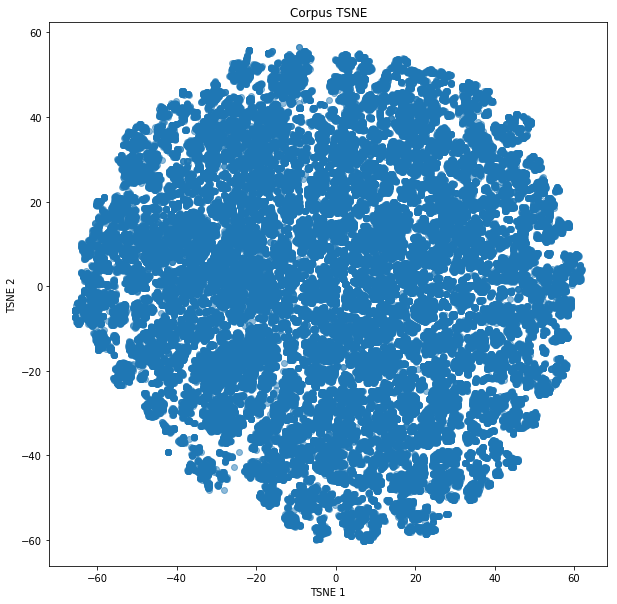

In [331]:
dim1 = ctsne[:, 0]
dim2 = ctsne[:, 1]
plt.figure(figsize=[10,10])
plt.scatter(dim1, dim2, alpha=0.5)
plt.title("Corpus TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.savefig('../figs/corpusTSNE.tif', dpi = 600)
plt.show()

In [414]:
# Make Simple Models of HNF4A and CAR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from scipy import interp

In [372]:
data = pd.concat([search_reg[search_reg['NR'] == 'HN4A'], search_reg[search_reg['NR']== 'CAR']])

In [373]:
data[:10]

,binding,chrom,chromstart,chromend,NR
0,ACCTGAGGTCAGGAGTTCAACACC,chr20,34390731,34391130,HN4A
0,GATAGACTGGATTCTGGTTCATCTAC,chr19,46189968,46190375,HN4A
0,GTCAAAGGTCACACCATGCACTTGAATCTC,chr6,13544959,13545363,HN4A
0,AAGTTACTTGAGCTTCGACTTGGAAGAT,chr15,58400934,58401338,HN4A
0,AACACAGGTCACTGTTCGGGTCAGTTTC,chr21,44958840,44959244,HN4A
0,GTCAAAGGTCAAACTGTGTACTTGATCTCT,chr6,23559948,23560390,HN4A
0,CATTAAGGTCAGGAAGTTCAAAACG,chr1,231236211,231236624,HN4A
0,AGCCAACTGGGTAAACAACTTGACCTGA,chr7,95599173,95599577,HN4A
0,CAACCAGTTCAGAGGTTCACTTTG,chr8,143013245,143013758,HN4A
0,TTAGAAGTTCAGACTGGGCATTA,chr22,50400414,50400872,HN4A


In [433]:
X = np.array([oheSeqMod(i, 5) for i in data['binding']])
W = np.array([w2vEncode(i, mk_model, 5) for i in data['binding']])
y = data['NR'].astype('category').cat.codes.values

#Separate Training and Test Sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
w_train, w_test, y2_train, y2_test = train_test_split(W, y, test_size = 0.33, random_state = 42)

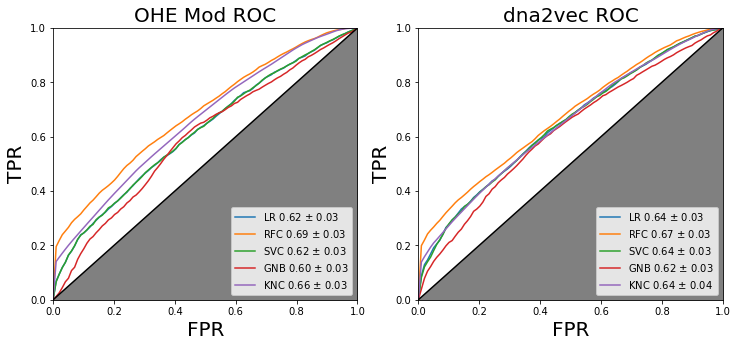

In [490]:
lr = LogisticRegression(solver = 'newton-cg')
rfc = RandomForestClassifier(n_estimators = 100, max_features= len(X[0]), max_depth=None, min_samples_split=2)
svc = LinearSVC(random_state = 42, max_iter = 5000)
gnb = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=15)
cv = StratifiedKFold(n_splits = 5)

model = [lr, rfc, svc, gnb, knc]
names = ['LR', 'RFC', 'SVC', 'GNB', 'KNC']
#Set Up Subplots
fig, ax = plt.subplots(1,2, figsize = [12, 5])
#Train Models and Create ROC Curves 
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)
for clf in range(len(model)):
    aucs = []
    tprs = []
    for train, test in cv.split(X, y):
        model[clf].fit(X[train], y[train])
        if hasattr(model[clf], "predict_proba"):
            prob_pos = model[clf].predict_proba(X[test])[:, 1]
        else:  # use decision function
            prob_pos = model[clf].decision_function(X[test])
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fpr, tpr, _ = roc_curve(y[test], prob_pos)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, label=names[clf] + r' %0.2f $\pm$ %0.2f' % (mean_auc, std_auc))
ax[0].plot([0, 1], [0, 1], color='black')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('TPR', fontsize = 20)
ax[0].set_xlabel('FPR', fontsize = 20)
ax[0].legend(loc = 'lower right')
ax[0].fill_between(x = [0,1], y1 = [0,1], color = 'gray')
ax[0].set_title('OHE Mod ROC', fontsize = 20)

for clf in range(len(model)):
    aucs = []
    tprs = []
    for train, test in cv.split(W, y):
        model[clf].fit(W[train], y[train])
        if hasattr(model[clf], "predict_proba"):
            prob_pos = model[clf].predict_proba(W[test])[:, 1]
        else:  # use decision function
            prob_pos = model[clf].decision_function(W[test])
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fpr, tpr, _ = roc_curve(y[test], prob_pos)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[1].plot(mean_fpr, mean_tpr, label=names[clf] + r' %0.2f $\pm$ %0.2f' % (mean_auc, std_auc))
ax[1].plot([0, 1], [0, 1], color='black')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('TPR', fontsize = 20)
ax[1].set_xlabel('FPR', fontsize = 20)
ax[1].legend(loc = 'lower right')
ax[1].fill_between(x = [0,1], y1 = [0,1], color = 'gray')
ax[1].set_title('dna2vec ROC', fontsize = 20)
fig.savefig('../figs/aucclass.tif', dpi = 600)
plt.show()

In [436]:
# Plotting Precision Recall Curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

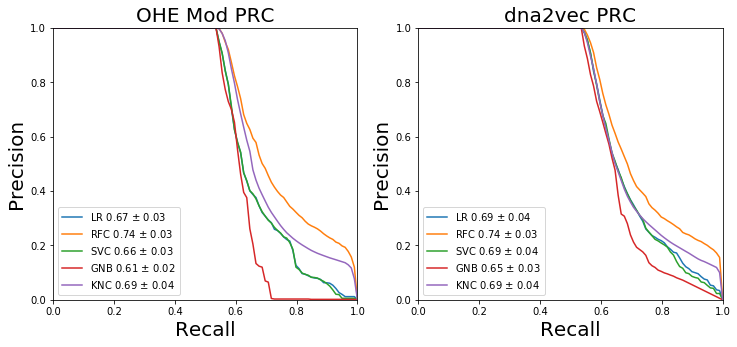

In [492]:
lr = LogisticRegression(solver = 'newton-cg')
rfc = RandomForestClassifier(n_estimators = 100, max_features= len(X[0]), max_depth=None, min_samples_split=2)
svc = LinearSVC(random_state = 42, max_iter = 5000)
gnb = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=15)
cv = StratifiedKFold(n_splits = 5)

model = [lr, rfc, svc, gnb, knc]
names = ['LR', 'RFC', 'SVC', 'GNB', 'KNC']
#Set Up Subplots
fig, ax = plt.subplots(1,2, figsize = [12, 5])
#Train Models and Create PRC Curves 
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)
for clf in range(len(model)):
    aucs = []
    tprs = []
    for train, test in cv.split(X, y):
        model[clf].fit(X[train], y[train])
        if hasattr(model[clf], "predict_proba"):
            prob_pos = model[clf].predict_proba(X[test])[:, 1]
        else:  # use decision function
            prob_pos = model[clf].decision_function(X[test])
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fpr, tpr, _ = precision_recall_curve(y[test], prob_pos)
        roc_auc = average_precision_score(y[test], prob_pos)
        aucs.append(roc_auc)
        tprs.append(interp(mean_fpr, fpr, tpr))
    mean_tpr = np.mean(tprs, axis=0)
    mean_score = np.mean(aucs)
    std_auc = np.std(aucs)
    ax[0].plot(mean_fpr, mean_tpr, label=names[clf] + r' %0.2f $\pm$ %0.2f' % (mean_score, std_auc))
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('Precision', fontsize = 20)
ax[0].set_xlabel('Recall', fontsize = 20)
ax[0].legend(loc = 'lower left')
ax[0].set_title('OHE Mod PRC', fontsize = 20)

for clf in range(len(model)):
    aucs = []
    tprs = []
    for train, test in cv.split(W, y):
        model[clf].fit(W[train], y[train])
        if hasattr(model[clf], "predict_proba"):
            prob_pos = model[clf].predict_proba(W[test])[:, 1]
        else:  # use decision function
            prob_pos = model[clf].decision_function(W[test])
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fpr, tpr, _ = precision_recall_curve(y[test], prob_pos)
        roc_auc = average_precision_score(y[test], prob_pos)
        aucs.append(roc_auc)
        tprs.append(interp(mean_fpr, fpr, tpr))
    mean_score = np.mean(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    std_auc = np.std(aucs)
    ax[1].plot(mean_fpr, mean_tpr, label=names[clf] + r' %0.2f $\pm$ %0.2f' % (mean_score, std_auc))
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Precision', fontsize = 20)
ax[1].set_xlabel('Recall', fontsize = 20)
ax[1].legend(loc = 'lower left')
ax[1].set_title('dna2vec PRC', fontsize = 20)
fig.savefig('../figs/prcclass.tif', dpi = 600)
plt.show()